In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [113]:

base_dir = "/content/drive/MyDrive/TURKCELL/weather_data/"

temperature_df = pd.read_csv(base_dir+"temperature.csv")
temperature_df.set_index("datetime", inplace=True)
temperature_df.index = pd.to_datetime(temperature_df.index)

city_mapping = {
    "Los Angeles": "Istanbul",
    "Las Vegas": "Ankara",
    "New York": "Izmir",
    "Vancouver": "Adana",
    "Seattle": "Antalya",
    "Philadelphia": "Bursa"
}

# Şehir isimlerini değiştirme
temperature_df.rename(columns=city_mapping, inplace=True)

# Sadece belirtilen şehirlerin kalmasını sağlama
temperature_df = temperature_df["Izmir"]

# Sonucu kontrol etme
temperature_df.fillna(method='ffill', inplace=True)
print(temperature_df)

datetime
2012-10-01 12:00:00           NaN
2012-10-01 13:00:00    288.220000
2012-10-01 14:00:00    288.247676
2012-10-01 15:00:00    288.326940
2012-10-01 16:00:00    288.406203
                          ...    
2017-11-29 20:00:00    284.980000
2017-11-29 21:00:00    284.980000
2017-11-29 22:00:00    284.980000
2017-11-29 23:00:00    284.980000
2017-11-30 00:00:00    284.980000
Name: Izmir, Length: 45253, dtype: float64


<ipython-input-113-abfea6eb9ef4>:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temperature_df.fillna(method='ffill', inplace=True)


In [114]:
def df_to_X_y(df, window_size=24):
  df_as_np = df.to_numpy()
  X, y = [], []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [115]:
window_size = 6  # Geçmiş X saati kullanmak
temperature_df = temperature_df.drop(temperature_df.index[0])
X, y = df_to_X_y(temperature_df, window_size)
X.shape, y.shape

((45246, 6, 1), (45246,))

In [116]:
X_train, y_train = X[:40000], y[:40000]
X_val, y_val = X[40000:43000], y[40000:43000]
X_test, y_test = X[43000:], y[43000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((40000, 6, 1), (40000,), (3000, 6, 1), (3000,), (2246, 6, 1), (2246,))

In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((window_size,1)))
model1.add(LSTM(96))
model1.add(Dense(8, "relu"))
model1.add(Dense(1, "linear"))

model1.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 96)                  │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 8)                   │             776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,417 (150.07 KB)

 Trainable params: 38,417 (150.07 KB)

 Non-trainable params: 0 (0.00 B)

In [118]:
cp = ModelCheckpoint("/content/drive/MyDrive/TURKCELL/MODELS/modelIZM/modelIZM.keras", save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [119]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp])

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 78999.8828 - root_mean_squared_error: 281.0602 - val_loss: 77954.4609 - val_root_mean_squared_error: 279.2032
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 70439.4766 - root_mean_squared_error: 265.3878 - val_loss: 64600.9961 - val_root_mean_squared_error: 254.1673
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 55971.2969 - root_mean_squared_error: 236.5316 - val_loss: 47313.6797 - val_root_mean_squared_error: 217.5171
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 39298.8320 - root_mean_squared_error: 198.1570 - val_loss: 31149.0137 - val_root_mean_squared_error: 176.4908
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 24623.2852 - root_mean_squared_error: 156.7994 - val_loss: 17591.4785 - val_root_mean_squared_error: 132.6329
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 12698.7061 - root_mean_squared_error: 112.5110 - val_loss: 7728.8252 - val_roo

In [120]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/TURKCELL/MODELS/modelIZM/modelIZM.keras")


In [121]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={"Test Predictions:":test_predictions, "Actual Values:":y_test})
test_results

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,Test Predictions:,Actual Values:
0,287.757721,288.33
1,288.283478,291.06
2,291.506683,292.90
3,293.820404,294.23
4,294.997894,294.84
...,...,...
2241,285.061432,284.98
2242,285.061432,284.98
2243,285.061432,284.98
2244,285.061432,284.98


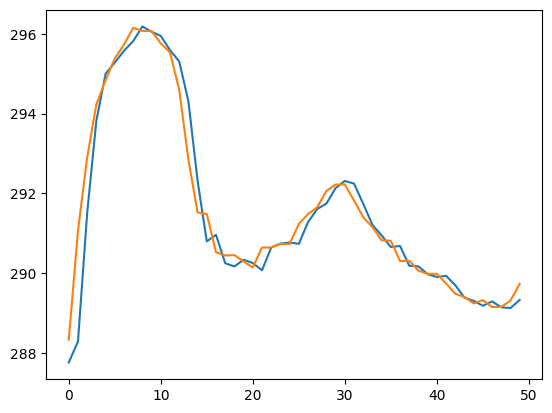

In [125]:
plt.plot(test_results["Test Predictions:"][:50])
plt.plot(test_results["Actual Values:"][:50])
plt.savefig("/content/drive/MyDrive/TURKCELL/MODELS/modelIZM/graph50")